<div dir=rtl>

# עיבוד שפה טבעית (20225211) 2023-2024 - תרגיל 2 שאלה 3

על ידי: פן אייל, קורן אביטבול

</div>

<div dir=rtl>

# התקנות

כמו במקרה הקודם, נוכל להשתמש בחבילות עיבוד השפה של [האגינגפייס](https://huggingface.co/) על-מנת לטעון את הדאטא.
כיוון שאנחנו טוענים דאטא בפורמט מטוקנז של UD, נצטרך להתקין גם חבילה התומכת בו.

</div>

In [180]:
!pip install datasets -q
!pip install tokenizers -q
!pip install conllu -q

<div dir=rtl>

# ייבוא

נצטרך כמעט את כל החבילות שהתקנו עבור הרשת הנשנית למסמכים.

</div>

In [181]:
import matplotlib.pyplot as plt  # for plotting
import pandas as pd  # only to show some data in a nice table
import torch
import time

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import WhitespaceSplit
from tokenizers.trainers import WordLevelTrainer

from datasets import load_dataset
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm  # progress bar

<div dir=rtl>
נתעלם משגיאות warning ונמחק את הprogress bar לאחר שסיים בשביל הדפסת המחברת ל PDF בצורה יפה יותר.
</div>

In [182]:
import warnings
warnings.filterwarnings('ignore')

TQDM_LEAVE = False

<div dir=rtl>

# זרע הפורענות

משהו שכדאי לעשות בזמן שמפתחים מודל הוא להמעיט באקראיות ככל הניתן.
בחבילות הנומריות של פייתון כמו numpy ו-pytorch יש הרבה מאוד אלמנטים אקראיים, כמו איך פרמטרים מאותחלים, או באיזה סדר נופל דאטאסט אם אנחנו בוחרים לערבב אותו בכל איטרציה (מומלץ באופן כללי, לא נממש הפעם).
הדרך שלנו לשלוט באלמנטים האלה כדי שיהיו זהים בכל הרצה (ובין היתר, להקל על בדיקת התרגיל) היא לקבוע זרע אקראי בתחילת ההרצה, שממנו תנבע האקראיות באופן דטרמיניסטי. הבה:

</div>

In [183]:
SEED = 5784

import random
from numpy import random as nprnd

random.seed(SEED)
nprnd.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

<div dir=rtl>

# מה בדאטא?

כמו בניתוח סנטימנט, אנחנו רוצים לדעת עם מה יש לנו עסק. לטעון מתוך UD זה קל עם חבילת datasets, ובשביל לגשת לשדות השונים, ניתן להיעזר ב[דף התיעוד](https://huggingface.co/datasets/universal_dependencies).
אותנו מעניין רק הטקסט וחלקי הדיבר UPOS (בשלב הזה) ולכן נסתכל על כמה דוגמאות:

</div>

In [184]:
pd.set_option('display.max_colwidth', None)
dataset = load_dataset(
   'universal_dependencies', 'cu_proiel')
dataset.set_format(type="pandas", columns=["text", "tokens", "upos"])
dataset['validation'][:10]

text  \
0                                      остави тоу даръ твои прѣдъ олътаремъ ꙇ шедъ прѣжде съмири сѧ съ братромъ своимъ и тогда пришедъ принеси даръ твои   
1  Бѫди оувѣщаѩ сѧ съ сѫпьремь своимь скоро доньдеже еси на пѫти съ нимь да не прѣдастъ тебе сѫдии ꙇ сѫдии тѧ прѣдастъ слоуѕѣ ꙇ въ темьницѫ въвръжетъ тѧ   
2                                                                                                                                        аминь г҃лѭ тебѣ   
3                                                                                               не изидеши отъ тѫдѣ доньдеже въздаси послѣдьнии кодрантъ   
4                                                                                                                     Слꙑшасте ѣко речено бꙑⷭ҇ древънимъ   
5                                                                                                                                   не прѣлюбꙑ сътвориши   
6                                                   азъ же г҃лѭ вамъ ѣко вьсѣкъ иже вьзьритъ на женѫ съ похотиѭ юже любꙑ сътвори съ неѭ въ с҃рдци своемь   
7                                                                                         аще же око твое десное съблажнаатъ тѧ ꙇзьми е и връзи отъ тебе   
8                                                          оунѣе бо ти естъ да погꙑблетъ единъ оудъ твоихъ а не вьсе тѣло твое въвръжено бѫдетъ въ ꙉеонѫ   
9                                                                                        ꙇ аште десна твоѣ рѫка съблажнаатъ тѧ оусѣци ѭ и връзи отъ себе   

                                                                                                                                                                               tokens  \
0                                              [остави, тоу, даръ, твои, прѣдъ, олътаремъ, ꙇ, шедъ, прѣжде, съмири, сѧ, съ, братромъ, своимъ, и, тогда, пришедъ, принеси, даръ, твои]   
1  [Бѫди, оувѣщаѩ, сѧ, съ, сѫпьремь, своимь, скоро, доньдеже, еси, на, пѫти, съ, нимь, да, не, прѣдастъ, тебе, сѫдии, ꙇ, сѫдии, тѧ, прѣдастъ, слоуѕѣ, ꙇ, въ, темьницѫ, въвръжетъ, тѧ]   
2                                                                                                                                                                 [аминь, г҃лѭ, тебѣ]   
3                                                                                                                   [не, изидеши, отъ, тѫдѣ, доньдеже, въздаси, послѣдьнии, кодрантъ]   
4                                                                                                                                            [Слꙑшасте, ѣко, речено, бꙑⷭ҇, древънимъ]   
5                                                                                                                                                            [не, прѣлюбꙑ, сътвориши]   
6                                                           [азъ, же, г҃лѭ, вамъ, ѣко, вьсѣкъ, иже, вьзьритъ, на, женѫ, съ, похотиѭ, юже, любꙑ, сътвори, съ, неѭ, въ, с҃рдци, своемь]   
7                                                                                                        [аще, же, око, твое, десное, съблажнаатъ, тѧ, ꙇзьми, е, и, връзи, отъ, тебе]   
8                                                                    [оунѣе, бо, ти, естъ, да, погꙑблетъ, единъ, оудъ, твоихъ, а, не, вьсе, тѣло, твое, въвръжено, бѫдетъ, въ, ꙉеонѫ]   
9                                                                                                       [ꙇ, аште, десна, твоѣ, рѫка, съблажнаатъ, тѧ, оусѣци, ѭ, и, връзи, отъ, себе]   

                                                                                                upos  
0                              [16, 14, 0, 6, 2, 0, 9, 16, 14, 16, 11, 2, 0, 6, 9, 14, 16, 16, 0, 6]  
1  [17, 16, 11, 2, 0, 6, 14, 5, 17, 2, 0, 2, 11, 5, 14, 16, 11, 0, 9, 0, 11, 16, 0, 9, 2, 0, 16, 11]  
2                                                                                     

<div dir=rtl>

המממ. קצת פחות ברור מה שקורה פה מאשר בדוגמת המסמכים השלמים. קודם כל, אנחנו לא דוברים סלאבית כנסייתית עתיקה. [הנה](https://en.wikipedia.org/wiki/Old_Church_Slavonic) ערך הויקיפדיה שלה ו[הנה](https://www.languagesgulper.com/eng/Slavonic.html) הסבר נוסף, והם יספרו לנו על תכונות של השפה שאולי יעזרו לנו להבין בהמשך אם יש תופעות שכדאי להתייחס אליהן מפורשות.

הדבר השני שאנחנו מתקשים איתו הוא פורמט התגים, שמופיעים כאן אחרי שכבר מופו לאינדקסים ע"י מי שהזין אותם לשרתי האגינגפייס. למזלנו, דאגו לנו גם לשמירת המיפוי בתוך הדאטאסט, וניתן לגשת אליו מתוך כל אחד מחיתוכי הדאטא (splits).

</div>

In [185]:
val_tags = dataset['validation'].features['upos'].feature.names
[f'{i:2}: {p}' for (i,p) in enumerate(val_tags)]

[' 0: NOUN',
 ' 1: PUNCT',
 ' 2: ADP',
 ' 3: NUM',
 ' 4: SYM',
 ' 5: SCONJ',
 ' 6: ADJ',
 ' 7: PART',
 ' 8: DET',
 ' 9: CCONJ',
 '10: PROPN',
 '11: PRON',
 '12: X',
 '13: _',
 '14: ADV',
 '15: INTJ',
 '16: VERB',
 '17: AUX']

<div dir=rtl>

סקירת-שפיות קצרה של הדאטא מהתא הקודם תראה לנו שבאמת ברוב המשפטים יש פועל (16), כפי שאנו מצפים מכל שפה, ושיש כמות סבירה של שמות עצם (0). נשים לב שאו שזה מקור שנכתב (בעת העתיקה) ללא סימני פיסוק (1), או שהם הוסרו בעת עריכת המשאב.

1. מצאו משפט מהקישור השני על השפה (לעיל) שמסביר מדוע הפעלים נמצאים במקומות מגוונים על-פני המשפטים שדגמנו.

</div>

---

**"Old Church Slavonic had apparently a free word order, all possible orders of subject, object and verb are found"**

---

<div dir=rtl>

כיוון שאנחנו חשדנים.ות מטבענו, ולא נרצה שנאמן את המודל על רשימת תגים מסוימת ואח"כ נבחן אותו על אינדקסים לא-תואמים (מה שיכול לגרום לכך שכל החיזויים שלנו לשמות עצם יפורשו כחיזויים לפעלים), נכתוב קוד קצר שמוודא שסדר התגים זהה עבור אימון, ולידציה ומבחן.

2. כתבו קוד שמוודא את סדר התגים לשלושת חלקי הדאטאסט. ניתן להשתמש בפונקציית `assert`.

</div>

In [186]:
### for exercise 2 ###

array = []
for group in ['train', 'validation', 'test']:
  tags = dataset[group].features['upos'].feature.names
  array.append(tags)
assert array[0] == array[1] == array[2]

<div dir=rtl>

# טוקנייזר

בעית הטיקנוז שלנו קלה אפילו יותר מזו שהיתה בניתוח סנטימנט. המסמכים שלנו באים עם חלוקה לטוקנים מראש, ולכן אפשר פשוט להעביר לטוקנייזר שנבנה בתור ברירת מחדל את הפרמטר לפיו המידע שהוא מקבל כבר עבר "טרום-טוקניזציה".
על-כן:
1. נטען את הדאטאסט
1. ניצור טוקנייזר פשוט
1. נגדיר לו את התבנית למילים לא ידועות `UNK` ואת תבנית הריפוד `PAD`
1. נאמן את הטוקנייזר
1. נספר לו איך לרפד.

אחר-כך נצטרך לטפל גם בטוקנייזר עבור התגים, בעיקר כדי לשמור על מדיניות ריפוד אחידה (המודולים ב-`torch` יצפו לאורך רצפים אחידים בין הקלט לתגים).
בשני המקרים נעשה משהו קצת מלוכלך בשביל ליצור לטוקנייזר מחרוזת כקלט. עבור הטוקנים, נגדיר פונקציה שמכניסה רווחים שאחר-כל האימון של הטוקנייזר יוציא, ועבור התגים, כיוון שהם נטענו בפורמט `int`, נריץ עליהם פונקציית `str()`.

</div>

In [187]:
PAD_ID = 0

def map_instance_to_whitespace_tokenizable_text(inst) -> str:
    return " ".join(inst['tokens'])

def make_tokenizers():
    dataset = load_dataset("universal_dependencies", "cu_proiel", split="train")
    tokenizer = Tokenizer(WordLevel(unk_token="<UNK>"))
    tokenizer.pre_tokenizer = WhitespaceSplit()
    trainer = WordLevelTrainer(special_tokens=["<PAD>", "<UNK>"])
    tokenizer.train_from_iterator([map_instance_to_whitespace_tokenizable_text(i) for i in dataset],
                                  trainer=trainer,
                                  length=len(dataset))
    tokenizer.enable_padding(pad_id=PAD_ID, pad_token="<PAD>")

    tag_tokenizer = Tokenizer(WordLevel(vocab={str(i): i for i in range(len(val_tags)+1)}))
    tag_tokenizer.enable_padding(pad_id=len(val_tags), pad_token=str(len(val_tags)))
    return tokenizer, tag_tokenizer

In [188]:
tokenizer, tag_tokenizer = make_tokenizers()

tokenizer.save("ud-cu-tokenizer.json", pretty=True)
tag_tokenizer.save("ud-cu-tag-tokenizer.json", pretty=True)

print(tokenizer.get_vocab_size())
print(tag_tokenizer.get_vocab_size())

7745
19


<div dir=rtl>

שימו לב שקיבלנו אוצר מילים די קטן לטוקנים, כיאה לדאטאסט קטן. הולכים להיות לנו הרבה מאוד `UNK` בולידציה ובטסט.
19 תגים זה המספר הרצוי, שכן יש 18 תגים בסכימת UPOS, והוספנו תג ריפוד.

</div>

<div dir=rtl>

# בניית מתייג חלקי דיבר

נתחיל בהמרת המעבד שלנו ל-GPU:

</div>

In [189]:
device = "cuda" if torch.cuda.is_available() else "cpu"

<div dir=rtl>

## הגדרת המודל

המודל הבסיסי שלנו זהה לזה שהשתמשנו בו עבור הרשת לסיווג טקסט שלם, עם הבדל אחד מאוד חשוב: הפלט שלה צריך להיות ברמת הטוקן; לא לוקחים רק את האחרון אלא את כל הסט שיוצא מה-LSTM, ואותו מעבירים לשכבה לינארית.

**שימו לב:** בהמשך נראה שפונקציית ההפסד שלנו מקבלת ציונים לא-מנורמלים עבור הקלאסים (חלקי דיבר, במקרה שלנו) ומבצעת את ה-`softmax` כחלק מהחישוב. אל תעבירו את הפלט בפונקציה שמבצעת חישוב דומה.

3. ממשו את `__init__()` ואת `forward()`. שימו לב לפרמטרים שהשתנו ביחס להדרכת תיוג המסמכים.

![](https://discuss.pytorch.org/uploads/default/original/2X/e/e7496a33d835f085d800ee17c0ade05895a89551.png)<br>

</div>

In [190]:
class PosTagger(nn.Module):
    def __init__(self,
                 embedding_dim: int,
                 hidden_size: int,
                 num_tags: int,
                 num_layers: int) -> None:
        super().__init__()

        ### for exercise 3.1 ###

        # The embedding layer converts token indices to vectors
        self.embedding = nn.Embedding(tokenizer.get_vocab_size(),
                              embedding_dim,
                              padding_idx=tokenizer.padding["pad_id"])
        # The LSTM takes embedded sequences as input
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        # The linear layer maps from hidden state space to tag space
        self.fc = nn.Linear(hidden_size, num_tags)


    def forward(self, x) -> torch.Tensor:

        ### for exercise 3.2 ###

        # Pass input through the embedding layer
        embedded = self.embedding(x)
        # Pass the embedded sequence through the LSTM layer
        lstm_out, _ = self.lstm(embedded)
        # Convert LSTM output to tag space using the linear layer
        tag_space = self.fc(lstm_out)

        # Apply softmax to convert tag scores to probabilities
        tag_scores = nn.functional.softmax(tag_space, dim=2)

        return tag_scores

<div dir=rtl>

## אימון ו-ולידציה

ההבדל העיקרי בפרקטיקת האימון אל מול סיווג מסמכים היא שיש גרדיאנט שמחושב עבור כל אחד מהטוקנים בנפרד: לכל אצווה (batch) יהיו לנו מספר תחזיות לא כגודלה אלא כסכום אורכי המשפטים שבה.
עיינו בקפידה ב[תיעוד](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) מודול ההפסד שנשתמש בו וחישבו היטב מה הקלט שלו צריך להיות.

4.1 ממשו את חישוב ההפסד ופעפועו. שימו לב לגדלי הטנסורים המשתתפים. שני רמזים בהקשר זה:
* אין לדאוג עדיין לטוקני הריפוד. אנחנו לא נרצה להשתמש בתחזיות שלהם כמובן, אבל הטיפול בהם קורה בשלב אתחול ההפסד.
* גשו לתיעוד של `torch.tensor` ועמדו על ההבדל בין הפעולות `view()` ו-`permute()`.

4.2. ממשו את חישוב המטריקה. אנו נמדוד דיוק פשוט (accuracy), ולצורך כך אותחלו עבורכם משתני-עזר לפני הלולאה. כאן אנחנו כן דואגים לטוקני הריפוד.

</div>

In [191]:
def train(model: PosTagger,
          optimizer: optim.Optimizer,
          loss_fn: nn.CrossEntropyLoss,
          dataloader: DataLoader,
          curr_epoch: int) -> dict:
    model.train()
    total = 0
    correct = 0
    for batch in tqdm(dataloader, desc=f"Epoch {curr_epoch} - Training", leave=TQDM_LEAVE):
        optimizer.zero_grad()
        sentences = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        probs = model(sentences)

        ### for exercise 4.1 ###

        one_hot_labels = nn.functional.one_hot(labels, num_classes=19).float()
        loss = loss_fn(probs.view(-1), one_hot_labels.view(-1))
        loss.backward()
        optimizer.step()

        ###

        preds = probs.argmax(dim=2)

        ### for exercise 4.2 ###

        correct += (preds == labels).sum().item()
        total += labels.numel()

        ###

    return correct / total


def evaluate(model: PosTagger,
             dataloader: torch.utils.data.DataLoader) -> dict:
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():  # operations done in this block will not contribute to gradients
        for batch in tqdm(dataloader, desc=f"Evaluation", leave=TQDM_LEAVE):
            sentences = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            probs = model(sentences)
            preds = probs.argmax(dim=2)

            ### for exercise 4.2 ###

            correct += (preds == labels).sum().item()
            total += labels.numel()

    return correct / total

<div dir=rtl>

# רגע האמת

נחבר הכל ביחד. נגדיר את הקבועים שלנו, שבהמשך יהיו היפר-פרמטרים.

</div>

In [192]:
BATCH_SIZE = 24
EMB_DIM = 100
HIDDEN_DIM = 64
NUM_LAYERS = 2
EPOCHS = 5

<div dir=rtl>

נגדיר פונקציית-עזר לחילוץ מחרוזות האינדקסים מתוך מיפויי התגים, ונטען בעזרתה את הדאטאסט.

</div>

In [193]:
def deep_stringify(x):
    if type(x) == int:
        return str(x)
    return [deep_stringify(a) for a in x]

dataset = load_dataset("universal_dependencies", "cu_proiel")
dataset = dataset.map(lambda ins: {
    "input_ids": [e.ids for e in tokenizer.encode_batch(ins['tokens'],
                                                        is_pretokenized=True)],
    "labels": [e.ids for e in tag_tokenizer.encode_batch(deep_stringify(ins['upos']),
                                                        is_pretokenized=True)],
}, batched=True, batch_size=BATCH_SIZE)
dataset.set_format(type="torch", columns=["input_ids", "labels"])

train_dataloader = DataLoader(dataset["train"], batch_size=BATCH_SIZE)
val_dataloader = DataLoader(dataset["validation"], batch_size=BATCH_SIZE)
test_dataloader = DataLoader(dataset["test"], batch_size=BATCH_SIZE)

<div dir=rtl>

נאתחל מודל, מאפטם ופונקציית הפסד.

5. אתחלו את פונקציית ההפסד.

</div>

Epoch 0 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1:
Training Accuracy: 61.36%
Validation Accuracy: 67.96%


Epoch 1 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 2:
Training Accuracy: 67.33%
Validation Accuracy: 72.76%


Epoch 2 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 3:
Training Accuracy: 72.31%
Validation Accuracy: 76.76%


Epoch 3 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 4:
Training Accuracy: 74.67%
Validation Accuracy: 77.27%


Epoch 4 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 5:
Training Accuracy: 75.00%
Validation Accuracy: 77.40%
Time to finish: 9.079055786132812 seconds


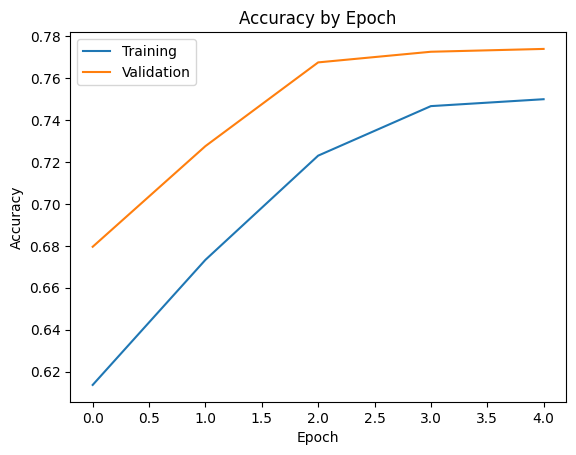

In [194]:
model = PosTagger(embedding_dim=EMB_DIM,
                  hidden_size=HIDDEN_DIM,
                  num_layers=NUM_LAYERS,
                  num_tags=tag_tokenizer.get_vocab_size()).to(device)
optimizer = optim.Adam(model.parameters())

### for exercise 5

loss_fn = nn.CrossEntropyLoss()

###

start = time.time()

train_accuracies = []
validation_accuracies = []
for epoch in range(EPOCHS):
    train_acc = train(model, optimizer, loss_fn, train_dataloader, epoch)
    val_acc = evaluate(model, val_dataloader)
    print(f"Epoch {epoch + 1}:")
    print(f"Training Accuracy: {100 * train_acc:.2f}%")
    print(f"Validation Accuracy: {100 * val_acc:.2f}%")
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

end = time.time()
print(f"Time to finish: {end - start} seconds")

plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies, label="Training")
plt.plot(validation_accuracies, label="Validation")
plt.legend();

<div dir=rtl>

# ניתוח

6. בתיבת הטקסט להלן, תארו את הגרף שיצא לכם לעיל. הציעו לפחות שני שינויים בהיפר-פרמטרים שלדעתכם עשויים לשפר את התוצאה **וממשו אותם**. לכל ניסוי שכפלו את תיבת הקוד לעיל, שנו את מה שצריך, והריצו מחדש. **השתמשו בשמות משתנים חדשים עבור המודלים והתוצאות**. ניתן לוותר על הדפסות המספרים באפוקי הביניים ולהסתפק בתוצאות הסוף ובגרף.

7. שנו מאפיין של הניסוי ש**אינו** אחד מההיפר-פרמטרים המוגדרים. למשל, השתמשו בקלאס אחר מ-pytorch עבור הרשת הנשנית, המאפטם, או משהו אחר לבחירתכם. או הוסיפו שכבה לינארית למודל.

האם השינויים אכן הועילו?

</div>

<div dir=rtl>

#  ניתוח - תשובות

6. אנו רואים מהגרף שככל שמספר האפוקים גדל המודל לומד יותר ויותר טוב והדיוק שלו עולה גם עבור מדגם האימון וגם עבור מדגם הולידציה.  
שני שינויים אפשריים להיפר-פרמטרים שנבדוק הם:
* הגדלת מספר השכבות ברשת
* הגדלת ייצוג האמבדינגס  

  בניסוי הראשון הגדלנו את מספר האפוקים (מ5 ל100) ובניסוי השני את מספר האמבדינגס (מ100 ל1000).  
  בשני הניסויים ראינו שיפור ניכר בביצועים, ולכן נרציץ פעם שלישית עם שני השינויים בייחד.

7. שינינו את האופטימייזר להיות גרדיאנט דיסנט סטוכסטי. יש הרעה בתוצאות.

</div>

Epoch 0 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 2 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 3 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 4 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 5 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 6 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 7 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 8 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 9 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 10 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 11 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 12 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 13 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 14 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 15 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 16 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 17 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 18 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 19 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 20 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 21 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 22 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 23 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 24 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 25 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 26 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 27 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 28 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 29 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 30 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 31 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 32 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 33 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 34 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 35 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 36 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 37 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 38 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 39 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 40 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 41 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 42 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 43 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 44 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 45 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 46 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 47 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 48 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 49 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 50 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 51 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 52 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 53 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 54 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 55 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 56 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 57 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 58 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 59 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 60 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 61 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 62 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 63 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 64 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 65 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 66 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 67 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 68 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 69 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 70 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 71 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 72 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 73 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 74 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 75 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 76 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 77 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 78 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 79 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 80 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 81 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 82 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 83 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 84 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 85 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 86 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 87 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 88 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 89 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 90 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 91 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 92 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 93 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 94 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 95 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 96 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 97 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 98 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 99 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Time to finish: 100.36191082000732 seconds
Training Accuracy: 98.90%
Validation Accuracy: 94.69%


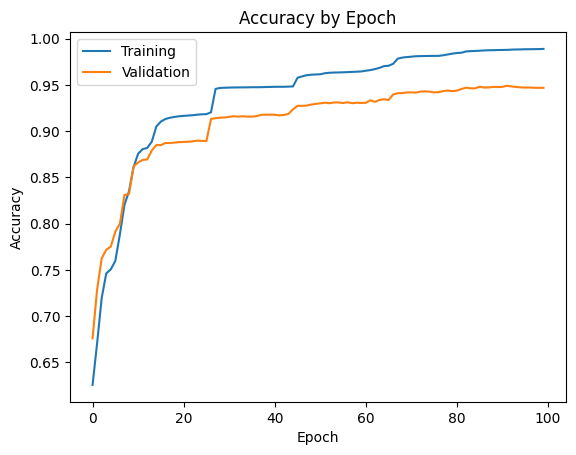

In [195]:
### for exercise 6 ###

# changing the EPOCHS from 5 to 100

BATCH_SIZE = 24
EMB_DIM = 100
HIDDEN_DIM = 64
NUM_LAYERS = 2
EPOCHS = 100

model_1 = PosTagger(embedding_dim=EMB_DIM,
                  hidden_size=HIDDEN_DIM,
                  num_layers=NUM_LAYERS,
                  num_tags=tag_tokenizer.get_vocab_size()).to(device)
optimizer_1 = optim.Adam(model_1.parameters())
loss_fn = nn.CrossEntropyLoss()

start = time.time()

train_accuracies_1 = []
validation_accuracies_1 = []
for epoch in range(EPOCHS):
    train_acc_1 = train(model_1, optimizer_1, loss_fn, train_dataloader, epoch)
    val_acc_1 = evaluate(model_1, val_dataloader)
    train_accuracies_1.append(train_acc_1)
    validation_accuracies_1.append(val_acc_1)

end = time.time()
print(f"Time to finish: {end - start} seconds")

print(f"Training Accuracy: {100 * train_acc_1:.2f}%")
print(f"Validation Accuracy: {100 * val_acc_1:.2f}%")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies_1, label="Training")
plt.plot(validation_accuracies_1, label="Validation")
plt.legend();

Epoch 0 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 2 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 3 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 4 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Time to finish: 6.86928915977478 seconds
Training Accuracy: 81.70%
Validation Accuracy: 84.05%


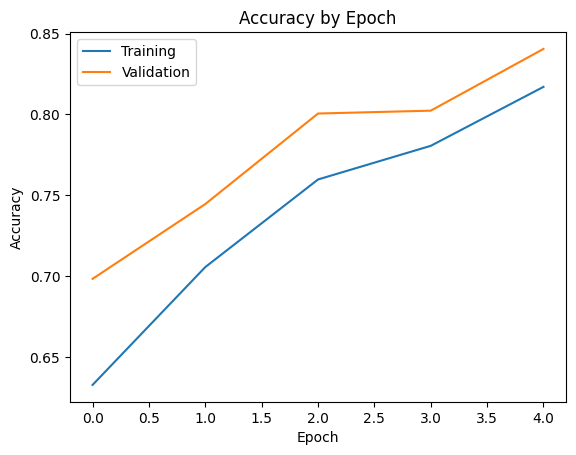

In [196]:
### for exercise 6 ###

# changing the EMB_DIM from 100 to 1000

BATCH_SIZE = 24
EMB_DIM = 1000
HIDDEN_DIM = 64
NUM_LAYERS = 2
EPOCHS = 5

model_2 = PosTagger(embedding_dim=EMB_DIM,
                  hidden_size=HIDDEN_DIM,
                  num_layers=NUM_LAYERS,
                  num_tags=tag_tokenizer.get_vocab_size()).to(device)
optimizer_2 = optim.Adam(model_2.parameters())
loss_fn = nn.CrossEntropyLoss()

start = time.time()

train_accuracies_2 = []
validation_accuracies_2 = []
for epoch in range(EPOCHS):
    train_acc_2 = train(model_2, optimizer_2, loss_fn, train_dataloader, epoch)
    val_acc_2 = evaluate(model_2, val_dataloader)
    train_accuracies_2.append(train_acc_2)
    validation_accuracies_2.append(val_acc_2)

end = time.time()
print(f"Time to finish: {end - start} seconds")

print(f"Training Accuracy: {100 * train_acc_2:.2f}%")
print(f"Validation Accuracy: {100 * val_acc_2:.2f}%")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies_2, label="Training")
plt.plot(validation_accuracies_2, label="Validation")
plt.legend();

Epoch 0 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 2 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 3 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 4 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 5 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 6 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 7 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 8 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 9 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 10 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 11 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 12 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 13 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 14 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 15 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 16 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 17 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 18 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 19 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 20 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 21 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 22 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 23 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 24 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 25 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 26 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 27 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 28 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 29 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 30 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 31 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 32 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 33 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 34 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 35 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 36 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 37 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 38 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 39 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 40 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 41 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 42 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 43 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 44 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 45 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 46 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 47 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 48 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 49 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 50 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 51 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 52 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 53 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 54 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 55 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 56 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 57 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 58 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 59 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 60 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 61 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 62 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 63 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 64 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 65 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 66 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 67 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 68 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 69 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 70 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 71 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 72 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 73 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 74 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 75 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 76 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 77 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 78 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 79 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 80 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 81 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 82 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 83 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 84 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 85 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 86 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 87 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 88 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 89 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 90 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 91 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 92 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 93 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 94 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 95 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 96 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 97 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 98 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 99 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Time to finish: 135.70232009887695 seconds
Training Accuracy: 99.13%
Validation Accuracy: 95.72%


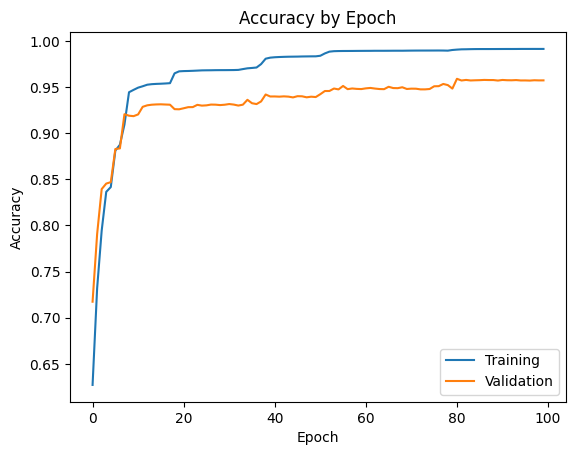

In [197]:
### for exercise 6 ###

# changing both the EPOCHS from 5 to 100 and the EMB_DIM from 100 to 1000

BATCH_SIZE = 24
EMB_DIM = 1000
HIDDEN_DIM = 64
NUM_LAYERS = 2
EPOCHS = 100

model_3 = PosTagger(embedding_dim=EMB_DIM,
                  hidden_size=HIDDEN_DIM,
                  num_layers=NUM_LAYERS,
                  num_tags=tag_tokenizer.get_vocab_size()).to(device)
optimizer_3 = optim.Adam(model_3.parameters())
loss_fn = nn.CrossEntropyLoss()

start = time.time()

train_accuracies_3 = []
validation_accuracies_3 = []
for epoch in range(EPOCHS):
    train_acc_3 = train(model_3, optimizer_3, loss_fn, train_dataloader, epoch)
    val_acc_3 = evaluate(model_3, val_dataloader)
    train_accuracies_3.append(train_acc_3)
    validation_accuracies_3.append(val_acc_3)

end = time.time()
print(f"Time to finish: {end - start} seconds")

print(f"Training Accuracy: {100 * train_acc_3:.2f}%")
print(f"Validation Accuracy: {100 * val_acc_3:.2f}%")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies_3, label="Training")
plt.plot(validation_accuracies_3, label="Validation")
plt.legend();

Epoch 0 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 2 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 3 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 4 - Training:   0%|          | 0/172 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Time to finish: 4.132359027862549 seconds
Training Accuracy: 71.86%
Validation Accuracy: 74.64%


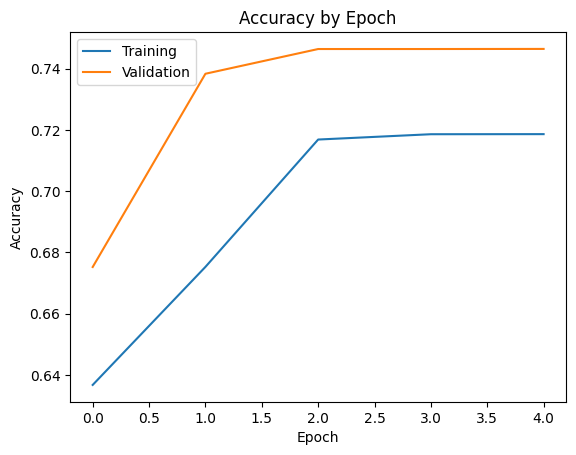

In [198]:
### for exercise 7 ###

# changing the optimizer from adam to SGD

BATCH_SIZE = 24
EMB_DIM = 100
HIDDEN_DIM = 64
NUM_LAYERS = 2
EPOCHS = 5

model_4 = PosTagger(embedding_dim=EMB_DIM,
                  hidden_size=HIDDEN_DIM,
                  num_layers=NUM_LAYERS,
                  num_tags=tag_tokenizer.get_vocab_size()).to(device)
optimizer_4 = optim.SGD(model_4.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

start = time.time()

train_accuracies_4 = []
validation_accuracies_4 = []
for epoch in range(EPOCHS):
    train_acc_4 = train(model_4, optimizer_4, loss_fn, train_dataloader, epoch)
    val_acc_4 = evaluate(model_4, val_dataloader)
    train_accuracies_4.append(train_acc_4)
    validation_accuracies_4.append(val_acc_4)

end = time.time()
print(f"Time to finish: {end - start} seconds")

print(f"Training Accuracy: {100 * train_acc_4:.2f}%")
print(f"Validation Accuracy: {100 * val_acc_4:.2f}%")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies_4, label="Training")
plt.plot(validation_accuracies_4, label="Validation")
plt.legend();

<div dir=rtl>

## טסט

8. מצאו את המודל הטוב ביותר מאלה שניסיתם עד כה והריצו (פעם אחת בלבד) על הטסט. הקבוצה עם התוצאה הטובה ביותר תקבל בונוס נקודה לציון הסופי בקורס.

</div>

In [199]:
### for exercise 8 ###

best_model = model_3

test_acc = evaluate(best_model, test_dataloader)
print(f"Test Accuracy: {100 * test_acc:.2f}%")

Evaluation:   0%|          | 0/48 [00:00<?, ?it/s]

Test Accuracy: 94.96%
